# Deriving Christchurch City Blocks from OSM

In [68]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [69]:
!pip install osmnx

In [70]:
import osmnx as ox
import pandas as pd
import geopandas as gpd

In [71]:
# setting blanket crs
crs = 'EPSG:2124'

<Axes: >

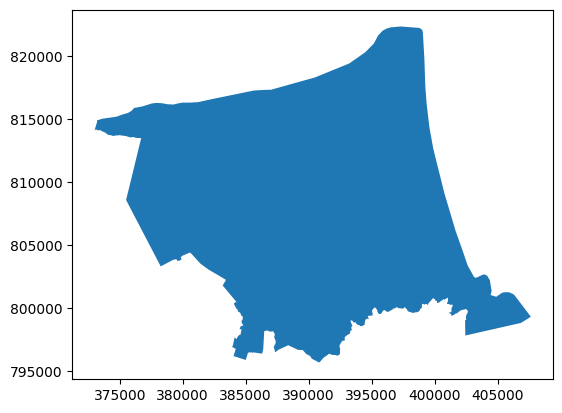

In [72]:
christchurch = 'Christchurch, New Zealand'

# Check boundary is correct
chc = ox.geocode_to_gdf(christchurch)
chc = chc.to_crs(crs)
chc.plot()

In [73]:
# get waterways an railways as geometries
waterways = ox.features_from_place(christchurch, tags={'waterway': True})
railways = ox.features_from_place(christchurch, tags={'railway': True})

# Create a geodataframe from each, applying the meblourne CRS to the dataframes
# (based on crs used in sentinel-1 method, EPSG:6283)
waterways_gdf = gpd.GeoDataFrame(waterways)
railways_gdf = gpd.GeoDataFrame(railways)

railways_gdf = railways_gdf.to_crs(crs)
waterways_gdf = waterways_gdf.to_crs(crs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# Choosing road types from the highways tag in OSM to act as city block boundaries
network_tags = {'highway':['motorway','trunk',
                          'primary','secondary',
                          'tertiary','residential',
                          'unclassified','motorway_link',
                          'trunk_link','primary_link',
                          'secondary_link','tertiary_link',
                          'living_street']
                }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
# deriving a geodataframe based on the roads specified in buffer function
roads = ox.features_from_place(christchurch, tags=network_tags)
roads_gdf = roads.to_crs(crs)

In [76]:
# I only want geometry types that are linestring for creating boundaries, so drop all other kinds

# Railways:
railways_gdf = railways_gdf[railways_gdf.geometry.type == 'LineString']

# Waterways:
waterways_gdf = waterways_gdf[waterways_gdf.geometry.type == 'LineString']

# Roads:
roads_gdf = roads_gdf[roads_gdf.geometry.type == 'LineString']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
# Define a function to buffer line features with variable widths

# The buffer is being used to ensure that any unused space between the network and
# the land use is not being considered. eg. spaces directly next to railways are
# not going to be publicly accessible
def buffer_lines(lines_gdf):
    # Different buffer widths will be used dependning on the feature, chosen based on best guesses
    # buffer widths need to be adjusted to fit crs.
    buffer_widths = {
        'motorway':8,
        'trunk':5,
        'primary':5,
        'secondary':4,
        'tertiary':4,
        'residential':3,
        'unclassified':2,
        'motorway_link':8,
        'trunk_link':5,
        'primary_link':5,
        'secondary_link':4,
        'tertiary_link':4,
        'living_street':4
    }
    lines_gdf['buffered_geometry'] = lines_gdf.apply(
        lambda row: row['geometry'].buffer(buffer_widths.get(row['highway'], 0)), axis=1)
    return lines_gdf

In [78]:
roads_gdf = buffer_lines(roads_gdf)

In [79]:
# For railways and waterways, no function needs to be defined
railways_gdf['buffered_geometry'] = railways_gdf.apply(lambda row: row['geometry'].buffer(5, 0), axis=1)
waterways_gdf['buffered_geometry'] = waterways_gdf.apply(lambda row: row['geometry'].buffer(10, 0), axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
# Set crs of buffered geometry columns
roads_gdf['buffered_geometry'] = roads_gdf['buffered_geometry'].set_crs(crs)
railways_gdf['buffered_geometry'] = railways_gdf['buffered_geometry'].set_crs(crs)
waterways_gdf['buffered_geometry'] = waterways_gdf['buffered_geometry'].set_crs(crs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
# creating a dataframe of just buffered geometry
road_buffers = roads_gdf
road_buffers['geometry'] = road_buffers['buffered_geometry']
road_buffers = road_buffers.drop(columns='buffered_geometry')

# railways:
railway_buffers = railways_gdf
railway_buffers['geometry'] = railway_buffers['buffered_geometry']
railway_buffers = railway_buffers.drop(columns=['buffered_geometry','highway'])

# waterways:
waterway_buffers = waterways_gdf
waterway_buffers['geometry'] = waterway_buffers['buffered_geometry']
waterway_buffers = waterway_buffers.drop(columns='buffered_geometry')

In [82]:
# Merge waterways and railways with the street network
merged_buffers = gpd.overlay(road_buffers, waterway_buffers, how='union')
merged_buffers = gpd.overlay(merged_buffers, railway_buffers, how='union')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-82-3b7f62dcd5c0>:3: UserWarning: `keep_geom_type=True` in overlay resulted in 28 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  merged_buffers = gpd.overlay(merged_buffers, railway_buffers, how='union')


In [83]:
# I want to clip the buffer dataframe to the boundary of christchurch
merged_buffers = gpd.clip(merged_buffers, chc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/geopandas/tools/clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [84]:
# using this, i can derive polygons shown in green using the difference function in gpd
# Calculate the difference between the city polygon and the road network
areas_with_no_roads = chc.difference(merged_buffers.unary_union)

In [85]:
# divide multipolgon into set of polygons
city_blocks = areas_with_no_roads.explode(index_parts=True)

# create a geodataframe for these areas
city_blocks = gpd.GeoDataFrame(geometry=city_blocks, crs=chc.crs)

In [86]:
city_blocks = city_blocks.to_crs(crs)
city_blocks.crs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Projected CRS: EPSG:2124>
Name: NZGD2000 / Mount Pleasant 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - South Island - Mount Pleasant meridional circuit area.
- bounds: (171.11, -43.96, 173.38, -42.69)
Coordinate Operation:
- name: Mount Pleasant 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [87]:
# Finding the area of each city block identified:
city_blocks['area'] = city_blocks['geometry'].area

In [88]:
# identify any city blocks with an area less than 10 metres
tiny_blocks = city_blocks[city_blocks['area'] < 10]
print('There are', len(tiny_blocks), 'city blocks less than 10m in Christchurch.')

There are 245 city blocks less than 10m in Christchurch.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
city_blocks.drop(tiny_blocks.index, inplace=True)

In [91]:
# Export city blocks to geopackage
city_blocks.to_file('/content/drive/MyDrive/FinalProject/Data/city-blocks/Christchurch/city-blocks.gpkg', driver='GPKG')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>: